In [ ]:
!pip install pygame


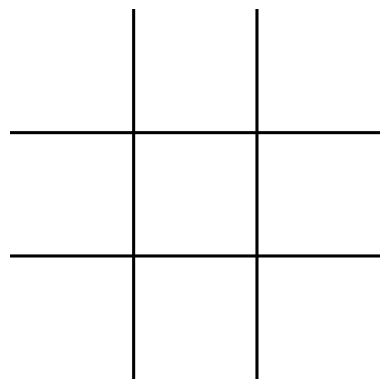

KeyboardInterrupt: 

In [ ]:
import pygame
import numpy as np
import random
import matplotlib.pyplot as plt

# 游戏参数
WINDOW_SIZE = 600
GRID_SIZE = 3
CELL_SIZE = WINDOW_SIZE // GRID_SIZE

# 颜色定义
WHITE = (255, 255, 255)
LINE_COLOR = (0, 0, 0)
X_COLOR = (242, 85, 96)  # 玩家 X
O_COLOR = (28, 170, 156)  # 玩家 O
BG_COLOR = (255, 255, 255)  # White background

# 创建游戏窗口和 Pygame 环境
pygame.init()

# 绘制棋盘
def draw_board():
    board_surface.fill(WHITE)
    # 绘制横线和竖线
    for i in range(1, GRID_SIZE):
        pygame.draw.line(board_surface, LINE_COLOR, (0, i * CELL_SIZE), (WINDOW_SIZE, i * CELL_SIZE), 5)
        pygame.draw.line(board_surface, LINE_COLOR, (i * CELL_SIZE, 0), (i * CELL_SIZE, WINDOW_SIZE), 5)

# 绘制 X 和 O
def draw_marks(board):
    for row in range(GRID_SIZE):
        for col in range(GRID_SIZE):
            if board[row, col] == 1:
                draw_x(row, col)
            elif board[row, col] == -1:
                draw_o(row, col)

# 绘制 X
def draw_x(row, col):
    pygame.draw.line(board_surface, X_COLOR, (col * CELL_SIZE + 15, row * CELL_SIZE + 15),
                     ((col + 1) * CELL_SIZE - 15, (row + 1) * CELL_SIZE - 15), 15)
    pygame.draw.line(board_surface, X_COLOR, ((col + 1) * CELL_SIZE - 15, row * CELL_SIZE + 15),
                     (col * CELL_SIZE + 15, (row + 1) * CELL_SIZE - 15), 15)

# 绘制 O
def draw_o(row, col):
    pygame.draw.circle(board_surface, O_COLOR, (col * CELL_SIZE + CELL_SIZE // 2, row * CELL_SIZE + CELL_SIZE // 2),
                       CELL_SIZE // 2 - 15, 15)

# 将 Pygame 表面转换为 NumPy 数组
def get_board_image():
    return np.array(pygame.surfarray.array3d(board_surface))

# 玩家操作
def player_move(env, player):
    valid_move = False
    while not valid_move:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                return None, None, None
            if event.type == pygame.MOUSEBUTTONDOWN:
                pos = pygame.mouse.get_pos()
                row, col = pos[1] // CELL_SIZE, pos[0] // CELL_SIZE
                action = row * GRID_SIZE + col
                if env.board[row, col] == 0:
                    valid_move = True
                    next_state, reward, done = env.step(action, player)
                    return next_state, reward, done
    return None, None, None

# Tic-Tac-Toe 环境
class TicTacToeEnv:
    def __init__(self):
        self.board = np.zeros((3, 3))  # 3x3 board, 0 = empty, 1 = agent, -1 = opponent
        self.done = False
        self.winner = None

    def reset(self):
        self.board = np.zeros((3, 3))
        self.done = False
        self.winner = None
        return self.board.flatten()

    def step(self, action, player):
        row, col = divmod(action, 3)
        if self.board[row, col] != 0:
            return self.board.flatten(), -10, True  # Invalid move, penalty
        self.board[row, col] = player

        if self.check_winner(player):
            self.done = True
            self.winner = player
            return self.board.flatten(), 10, self.done  # Positive reward for winning
        elif np.all(self.board != 0):
            self.done = True
            return self.board.flatten(), 0, self.done  # No winner, tie
        else:
            return self.board.flatten(), 0, self.done  # Continue playing

    def check_winner(self, player):
        for row in range(3):
            if np.all(self.board[row, :] == player):
                return True
        for col in range(3):
            if np.all(self.board[:, col] == player):
                return True
        if np.all(np.diagonal(self.board) == player):
            return True
        if np.all(np.diagonal(np.fliplr(self.board)) == player):
            return True
        return False

    def render(self):
        draw_board()
        draw_marks(self.board)  # Draw both X and O marks
        image = get_board_image()
        plt.imshow(image)
        plt.axis('off')  # Hide the axis
        plt.show()

# 游戏展示
def play_game(agent, env):
    state = env.reset()
    done = False
    while not done:
        # 玩家选择行动
        next_state, reward, done = player_move(env, player=-1)  # 玩家是 -1
        if done:
            print("Game Over! Player Wins!" if reward > 0 else "Game Over! It's a Tie.")
            break
        env.render()

        # 智能体选择行动
        action = agent.choose_action(state)
        print(f"Agent chooses action {action}")
        next_state, reward, done = env.step(action, player=1)  # 假设智能体为1号玩家
        agent.update_q_value(state, action, reward, next_state, done)
        state = next_state
        env.render()  # 智能体的回合渲染

        if done:
            print("Game Over! Agent Wins!" if reward > 0 else "Game Over! It's a Tie.")
            break

# Q-learning 智能体
class QLearningAgent:
    def __init__(self, action_space, epsilon=0.1, alpha=0.5, gamma=0.9):
        self.action_space = action_space
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.q_table = {}

    def get_q_value(self, state, action):
        if tuple(state) not in self.q_table:
            self.q_table[tuple(state)] = np.zeros(len(self.action_space))
        return self.q_table[tuple(state)][action]

    def update_q_value(self, state, action, reward, next_state, done):
        future_q_value = 0 if done else np.max(self.q_table.get(tuple(next_state), np.zeros(len(self.action_space))))
        current_q_value = self.get_q_value(state, action)
        new_q_value = current_q_value + self.alpha * (reward + self.gamma * future_q_value - current_q_value)
        self.q_table[tuple(state)][action] = new_q_value

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.action_space)
        else:
            return np.argmax(self.q_table.get(tuple(state), np.zeros(len(self.action_space))))

# 主函数和游戏循环
def main():
    agent = QLearningAgent(action_space=list(range(9)))
    env = TicTacToeEnv()

    while True:
        env.render()  # 渲染初始棋盘
        play_game(agent, env)  # 开始游戏

if __name__ == "__main__":
    board_surface = pygame.Surface((WINDOW_SIZE, WINDOW_SIZE))  # Pygame surface for drawing
    main()



In [6]:
!git config --global user.name "yzc03"
!git config --global user.email "yuanzicheng03@163.com"


fatal: not a git repository (or any of the parent directories): .git
